In [1]:
from extra_data import RunDirectory 
import h5py 
import numpy as np 
#%matplotlib widget
import matplotlib.pyplot as plt 
PREFIX='/gpfs/exfel/exp/SPB/202202/p003046'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import scipy.optimize
from scipy import signal
import seaborn as sns

# Apply the default theme
sns.set()

In [3]:
import xarray

def read_run_sync_trains(r, verbose=True):
    #clear_output(wait=False) 
    #sys.stderr.write(f'Processing run {r}...\n') 
    run = RunDirectory(path='/pnfs/xfel.eu/exfel/archive/XFEL/raw/SPB/202202/p003046/r%04d' % (r))  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()
    
    intensity_sase1_extra = sel['SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']
    intensity_preattenuator_sase1_extra = sel['SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']    
    motors_x_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_X.actualPosition.value']
    motors_y_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_Y.actualPosition.value']
    sidemic_extra = sel['SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels']

    # Put the data in xarray
    motor_x = motors_x_extra.xarray()
    motor_y = motors_y_extra.xarray()
    xgm = intensity_sase1_extra.xarray()
    xgm2 = intensity_preattenuator_sase1_extra.xarray()
    sidemic = sidemic_extra.xarray()
    
    directory = '/gpfs/exfel/u/scratch/SPB/202202/p003046/data' 
    agipd_frames_per_train = 202 # number of agipd frames per train
    with h5py.File(directory+'/r%04d_proc_radavg.h5' % (r)) as rad: 
        radavg = rad['entry_1']['radialavg'][:]
        trainIds = rad['entry_1']['trainId'][:]
        q = rad['entry_1']['q'][:]
    
    # Reshape the arrays from the radavg file to make them by train
    radavg = radavg.reshape((-1,agipd_frames_per_train,radavg.shape[1]))
    trainIds = trainIds.reshape((-1,agipd_frames_per_train))
    # Ensure all the trains are the same length
    if (trainIds == trainIds[:,:1]).all() != True:
        raise ValueError        
    if(verbose):
        print("Reshaping of radavg successful:", (trainIds == trainIds[:,:1]).all())
    trainIds = trainIds[:,0]
    
    # Put radavg in an xarray
    radavg = xarray.DataArray(data=radavg, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})

    # Find trains which are common between radavg and the rest
    common_trains = np.intersect1d(intensity_sase1_extra.train_id_coordinates(), trainIds)
    if verbose:
        print("Found %d common train IDs between radavg and the rest" % len(common_trains))

    # Find the indices of the common trainIds and keep only those
    common_train_idx = np.searchsorted(intensity_sase1_extra.train_id_coordinates(),common_trains)
    motor_x = motor_x[common_train_idx]
    motor_y = motor_y[common_train_idx]
    xgm = xgm[common_train_idx]

    # Find the indices of the common trainIds for radavg    
    common_train_idx = np.searchsorted(radavg.coords['trainId'].data,common_trains)
    radavg = radavg[common_train_idx]
    
    train_ids_eq = (motor_x.coords['trainId'].data == radavg.coords['trainId'].data)
    if verbose:
        print("Train IDs all match:", train_ids_eq.all())
    
    return xgm, motor_x, motor_y, radavg, xgm2, sidemic

In [6]:
def sync_pulses(xgm, radavg, xgm2):
    # Find out how many X-ray pulses per train

    npulses = np.sum(np.nanmean(xgm,axis=0) > 1.0)
    # For certain runs we actually receive more than 176 pulses, but the agipd will only record 176   
    npulses = min(npulses,176)
    agipd_frames_per_pulse = 176//npulses
    return xgm[:,:npulses], radavg[:,1:npulses*agipd_frames_per_pulse+1:agipd_frames_per_pulse,:], xgm2[:,:npulses]

def integrate_q_range(radavg, q_min = 0.73, q_max = 13, verbose=True):
    # q_min and q_max in 1/nm

    q = radavg.coords['q'].data
    q_min_idx = np.argmax(q > q_min)
    q_max_idx = np.argmax(q > q_max)
    if(verbose):
        print('Integrating between %g-%g 1/nm' % (q_min,q_max))   
    I = xarray.DataArray(data=np.nansum(radavg[:,:,q_min_idx:q_max_idx],axis=2), dims=('trainId', 'pulseNr'), coords={'trainId': radavg.coords['trainId'], 'pulseNr': radavg.coords['pulseNr']})
    return I

import pyFAI.azimuthalIntegrator
import extra_geom

def load_geom( run_n):
        geom = extra_geom.AGIPD_1MGeometry.from_crystfel_geom(PREFIX+'/scratch/geom/agipd_september_2022_v03.geom')
        pixel_size = 200e-6
        from extra_data import open_run
        run = open_run(proposal=3046,run=run_n)
        detector_distance = (run["SPB_IRU_AGIPD1M/MOTOR/Z_STEPPER"]['actualPosition'].ndarray()[0]+121)*1e-3

        from extra_data import open_run
        run = open_run(proposal=3046,run=run_n)
        energy = run['SPB_XTD2_UND/DOOCS/ENERGY']['actualPosition'].ndarray()[0] # in keV
        wavelength = 1.23984193e-9/energy # in m
                      
            
            
        #wavelength = 0.15498e-9 #8 keV
        assem, centre = geom.position_modules_fast(np.empty(geom.expected_data_shape))

        ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist = detector_distance,
                                                           poni1 = centre[0] * pixel_size,
                                                           poni2 = centre[1] * pixel_size,
                                                           pixel1 = pixel_size,
                                                           pixel2 = pixel_size,
                                                           rot1 = 0, rot2=0, rot3=0,
                                                           wavelength = wavelength)
        
        solid_angle = ai.solidAngleArray(shape=assem.shape)
        polarization = ai.polarization(shape=assem.shape,factor=1)
        corrections = np.ones_like(assem)
        corrections /= solid_angle
        corrections /= polarization
        q = ai.qArray(shape=assem.shape)
        npts = 256
        intrad = np.floor(q/(np.max(q)+1e-7)*256).astype(int)
        max_rad = npts
        geom = geom
        mask_file = PREFIX+'/scratch/geom/newer_mask.h5'
        with h5py.File(mask_file,'r') as f:
            good_pixels = (np.asarray(f['combined_mask']))
            good_pixels, centre = geom.position_modules_fast(good_pixels)
        ai = ai
        return solid_angle

def extract_gifs(r, verbose=True):
    run = RunDirectory(path=f'/gpfs/exfel/exp/SPB/202202/p003046/raw/r0{r}')  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()   
    sidemic_extra = sel['SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels']
    trains = sidemic_extra.train_id_coordinates()
    sidemic = sidemic_extra.xarray()
    return sidemic

def motor_y_from_sidemic(sidemic, step=20, start=0, px_size=0.0013):
    # One cannot fully trust that the motor_y motion results in a motion of the liquid sheet
    # so we'll use the sidemic to get the real y motion
    import skimage.registration
    run_shift = np.zeros((sidemic.shape[0],2))
    for i in np.arange(start+step,sidemic.shape[0],step):
        shift, error, phasediff = skimage.registration.phase_cross_correlation(sidemic[i-step], sidemic[i])
        run_shift[i] = shift
    return np.cumsum(run_shift[:,0])*px_size

In [7]:
# IPA thin run
run = 193
xgm, motor_x, motor_y, radavg, xgm2, sidemic = read_run_sync_trains(run, verbose=False)
# This run only had x-rays at every 4th detector frame
radavg_train = np.mean(radavg[:,1:177:4,:],axis=1)

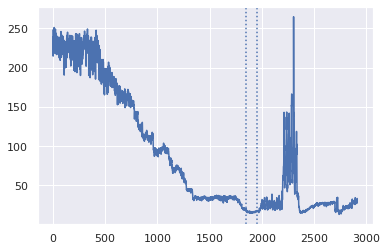

In [8]:
plt.figure()
plt.plot(np.nanmean(radavg_train,axis=1))
# Highlight the range we're gonna use, corresponding to the thinnest part of the sheet
plt.axvline(x=1850,ls=':')
plt.axvline(x=1950,ls=':')
plt.show()
rad_avg_thin = xarray.DataArray(data=np.nanmean(radavg_train[1850:1950],axis=0), dims=('q'), coords={'q': radavg.coords['q'].data})

In [9]:
# Find out how many ADUs are one photon
run = 193
r = RunDirectory(path='/gpfs/exfel/exp/SPB/202202/p003046/proc/r%04d' % run)
sel = r.select('SPB_DET_AGIPD1M-1/DET/*CH0:xtdf', 'image.data')
# Take an image with plenty of single photons
data = sel.train_from_index(1800)
import extra_geom
geom = extra_geom.AGIPD_1MGeometry.from_crystfel_geom('/gpfs/exfel/exp/SPB/202202/p003046'+'/scratch/geom/agipd_september_2022_v03.geom')
import extra_data  
modules_data = extra_data.stack_detector_data(data[1], 'image.data')

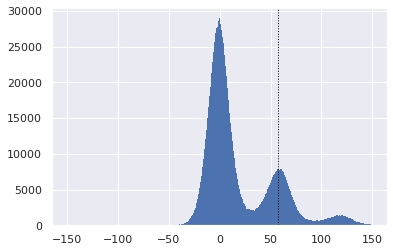

In [11]:
# Plot the histogram to find the one photon peak
import scipy.signal
plt.figure()
counts, bins, _ = plt.hist(modules_data[1].flatten(),bins=300, range=[-150,149],lw=0)
centers = (bins[:-1]+bins[1:])/2
peaks, _ = scipy.signal.find_peaks(counts, width=10)
plt.axvline(x=centers[peaks[1]],ls=':',color='black', lw=1)
ADUs_per_photon = centers[peaks[1]]
plt.show()

In [12]:
%cd p003046/scratch/filipe/xfel3046/offline/jupyter

/gpfs/exfel/u/scratch/SPB/202202/p003046/filipe/xfel3046/offline/jupyter


Fit error: 0.333449


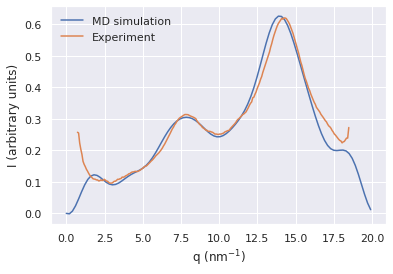

IPA depth from SAXS signal (assuming 65% beamline transmission) is 86 nm


In [13]:
gmx_data = np.loadtxt("../md/IPA/sq.xvg")
gmx_natoms = 984*12
data = gmx_data.copy()
# GROMACS does a per atom scattering
data[:,1] *= gmx_natoms

# Volume of the gmx box = 5 nm**3
gmx_volume = 5e-9**3 # m^3
gmx_area = 5e-9**2 # m^2
gmx_depth = 5e-9

# We're gonna take 2 mJ at 8keV as that's what the XGM gave
# This assumes no losses on the mirrors which is optimistic
ph_E_eV = 8000 # eV
ph_E = ph_E_eV * 1.60218e-19 # J
I0_E = 2e-3 # J
transmission = 0.65
I0 = I0_E/ph_E/gmx_area*transmission # ph/m^2

# AGIPD pixel area
pixel_area = 200e-6**2 # m^2
# pixel solid angle
detector_distance = 331e-3 # m
pixel_omega = pixel_area/detector_distance**2

Thomson_differential_cross_section = 2.8179403e-15**2 #m^2

sample_depth = 55e-9
depth_factor = sample_depth/gmx_depth

exp_data = rad_avg_thin

# Scale the simulated scattering to experimental conditions, per nm of depth of sample
depth_factor = 1e-9/gmx_depth
scaled_data = depth_factor*pixel_omega*Thomson_differential_cross_section*I0*data[:,1]
# Gromacs critically samples the SAXS pattern. 
# Let's oversample it to match the experimental data better
resampled_y, resampled_x = signal.resample(scaled_data, 100, t = data[:,0])

# Find what's the optimal depth of sample that matches the experimental data
f = scipy.interpolate.interp1d(resampled_x, resampled_y)
res = scipy.optimize.minimize_scalar(lambda depth: np.nansum((depth*f(exp_data.coords['q'].data)-exp_data.data/ADUs_per_photon)**2))
if(res.success != True):
    raise
else:
    print('Fit error: %f' % (res.fun))
sample_depth = res.x

plt.figure()
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('I (arbitrary units)')
plt.plot(resampled_x, sample_depth*resampled_y, label='MD simulation')

plt.plot(exp_data.coords['q'].data, exp_data.data/ADUs_per_photon, label='Experiment' )
plt.legend(frameon=False)
plt.savefig('../figures/S3_top_LJ_r193_thinnest_IPA_thickness_fit.pdf')
plt.show()
print('IPA depth from SAXS signal (assuming %d%% beamline transmission) is %d nm' % (100*transmission, sample_depth))

In [14]:
# Water thin run
run = 86
xgm, motor_x, motor_y, radavg, xgm2, sidemic = read_run_sync_trains(run, verbose=False)
# Take only every 4th detector frame just like for IPA
radavg_train = np.mean(radavg[:,1:177:4,:],axis=1)

In [15]:
rad_avg_water = xarray.DataArray(data=np.nanmean(radavg_train,axis=0), dims=('q'), coords={'q': radavg.coords['q'].data})

Fit error: 314.980456


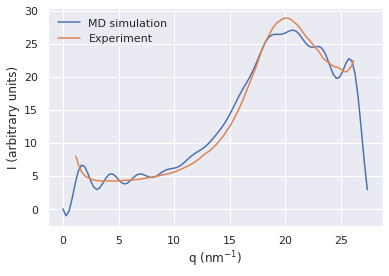

Water depth from SAXS signal (assuming 65% beamline transmission) is 2530 nm


In [16]:
gmx_data = np.loadtxt("../md/H2O/sq.xvg")
gmx_natoms = 4055*3
data = gmx_data.copy()
# GROMACS does a per atom scattering
data[:,1] *= gmx_natoms

# Volume of the gmx box = 5 nm**3
gmx_volume = 5e-9**3 # m^3
gmx_area = 5e-9**2 # m^2
gmx_depth = 5e-9

# We're gonna take 2 mJ at 8keV as that's what the XGM gave
# This assumes no losses on the mirrors which is optimistic
ph_E_eV = 8000 # eV
ph_E = ph_E_eV * 1.60218e-19 # J
I0_E = 2e-3 # J

transmission = 0.65
I0 = I0_E/ph_E/gmx_area*transmission # ph/m^2

# AGIPD pixel area
pixel_area = 200e-6**2 # m^2
# pixel solid angle
detector_distance = 213e-3 # m
pixel_omega = pixel_area/detector_distance**2

Thomson_differential_cross_section = 2.8179403e-15**2 #m^2

sample_depth = 55e-9
depth_factor = sample_depth/gmx_depth

exp_data = rad_avg_water
# Scale the simulated scattering to experimental conditions, per nm of depth of sample
depth_factor = 1e-9/gmx_depth
scaled_data = depth_factor*pixel_omega*Thomson_differential_cross_section*I0*data[:,1]
# Gromacs critically samples the SAXS pattern. 
# Let's oversample it to match the experimental data better
resampled_y, resampled_x = signal.resample(scaled_data, 100, t = data[:,0])

# Find what's the optimal depth of sample that matches the experimental data
f = scipy.interpolate.interp1d(resampled_x, resampled_y)
res = scipy.optimize.minimize_scalar(lambda depth: np.nansum((depth*f(exp_data.coords['q'].data)-exp_data.data/ADUs_per_photon)**2))
if(res.success != True):
    raise
else:
    print('Fit error: %f' % (res.fun))
sample_depth = res.x

plt.figure()
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('I (arbitrary units)')
plt.plot(resampled_x, sample_depth*resampled_y, label='MD simulation')



plt.plot(exp_data.coords['q'].data, exp_data.data/ADUs_per_photon, label='Experiment' )
plt.legend(frameon=False)
plt.savefig('../figures/S3_bottom_LJ_r86_water_thickness_fit.pdf')
plt.show()
print('Water depth from SAXS signal (assuming %d%% beamline transmission) is %d nm' % (100*transmission, sample_depth))

In [17]:
def IPA_thickness(exp_data, xgm_train):
    gmx_data = np.loadtxt("../md/IPA/sq.xvg")
    gmx_natoms = 984*12
    data = gmx_data.copy()
    # GROMACS does a per atom scattering
    data[:,1] *= gmx_natoms

    # Volume of the gmx box = 5 nm**3
    gmx_volume = 5e-9**3 # m^3
    gmx_area = 5e-9**2 # m^2
    gmx_depth = 5e-9

    # We're gonna take 2 mJ at 8keV as that's what the XGM gave
    # This assumes no losses on the mirrors which is optimistic
    ph_E_eV = 8000 # eV
    ph_E = ph_E_eV * 1.60218e-19 # J
    
    # We start by assuming a mJ and then rescale as necessary!
    I0_E = 1e-3 # J

    I0 = I0_E/ph_E/gmx_area # ph/m^2

    # AGIPD pixel area
    pixel_area = 200e-6**2 # m^2
    # pixel solid angle
    detector_distance = 331e-3 # m
    pixel_omega = pixel_area/detector_distance**2

    Thomson_differential_cross_section = 2.8179403e-15**2 #m^2

    # Scale the simulated scattering to experimental conditions, per nm of depth of sample and per mJ of incident energy
    depth_factor = 1e-9/gmx_depth
    scaled_data = depth_factor*pixel_omega*Thomson_differential_cross_section*I0*data[:,1]
    # Gromacs critically samples the SAXS pattern. 
    # Let's oversample it to match the experimental data better
    resampled_y, resampled_x = signal.resample(scaled_data, 100, t = data[:,0])

    # Find what's the optimal depth of sample that matches the experimental data
    f = scipy.interpolate.interp1d(resampled_x, resampled_y)
    if(exp_data.ndim > 1):
        sample_depth = np.zeros(exp_data.shape[0])
        for i in range(exp_data.shape[0]):
            # The actual incident energy in mJ. We're using 65% for beamline transmission which is reasonable for SPB/SFX nanofocus @ 8 keV
            I0_E_train = xgm_train.data[i]/1000.0 * 0.65
            res = scipy.optimize.minimize_scalar(lambda depth: np.nansum((depth*I0_E_train*f(exp_data.coords['q'].data)-exp_data[i].data/ADUs_per_photon)**2))
            if(res.success != True):
                raise
            sample_depth[i] = res.x
    else:
        res = scipy.optimize.minimize_scalar(lambda depth: np.nansum((depth*f(exp_data.coords['q'].data)-exp_data.data/ADUs_per_photon)**2))
        sample_depth = res.x
        if(res.success != True):
            raise

    return sample_depth

In [18]:
# IPA thin run
run = 193
xgm, motor_x, motor_y, radavg, xgm2, sidemic = read_run_sync_trains(run, verbose=False)
xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
# This run only had x-rays at every 4th detector frame
radavg_train = np.mean(radavg[:,1:177:4,:],axis=1)
xgm_train = np.mean(xgm,axis=1)

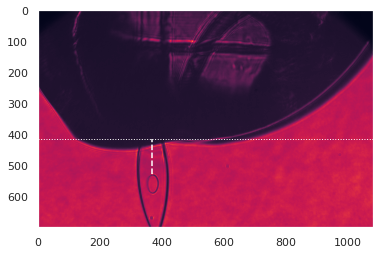

In [19]:
# Now need to find the distance to the nozzle
sidemic_193 = sidemic.data[0]
sidemic_end_193 = sidemic.data[-1]
plt.figure()
plt.imshow(sidemic_193[0:700,:])
nozzle_end = 415
plt.axhline(y=nozzle_end,color='w',ls=':',lw=1)
xray_pos = np.unravel_index(np.argmax(sidemic_193),sidemic_193.shape)
plt.plot((xray_pos[1], xray_pos[1]), (xray_pos[0], nozzle_end), 'w--')
plt.grid(None)
plt.show()
# 0.0013 is the effective pixel size given the downsampling
# and magnification used in the acquisition
distance_to_nozzle_193 = (xray_pos[0]-nozzle_end)*0.0013

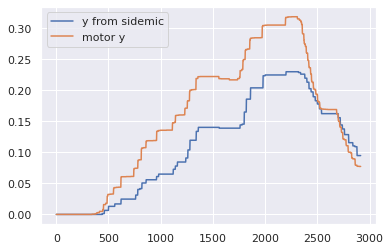

In [20]:
motor_y_sidemic = motor_y_from_sidemic(sidemic,start=400)
plt.figure()
plt.plot(motor_y_sidemic, label='y from sidemic')
plt.plot(motor_y-motor_y[0], label='motor y')
plt.legend()
plt.show()

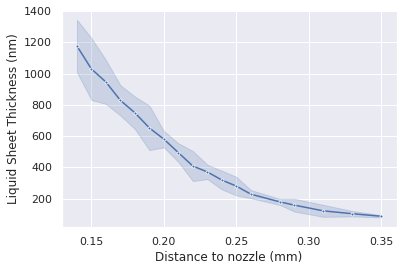

In [21]:
depth_193 = IPA_thickness(radavg_train, xgm_train)
motor_193 = motor_y_sidemic.data + distance_to_nozzle_193
motor_193_nominal = motor_y - motor_y[0] + distance_to_nozzle_193
plt.figure()
# We're only going to 1900 as afterwards we start to hit the rim
sns.lineplot(x = np.round(motor_193[:1900],2), y=depth_193[:1900], errorbar=('sd',3), marker='.', markers=True)
plt.xlabel('Distance to nozzle (mm)')
plt.ylabel('Liquid Sheet Thickness (nm)')
plt.savefig('../figures/3b_LJ_r193_IPA_vertical_scan_thickness_fit.pdf')
plt.show()

In [22]:
# IPA horizontal scan run
run = 194
xgm, motor_x, motor_y, radavg, xgm2, sidemic = read_run_sync_trains(run, verbose=False)
xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
# This run only had x-rays at every 4th detector frame
radavg_train = np.mean(radavg[:,1:177:4,:],axis=1)
xgm_train = np.mean(xgm,axis=1)

Tilt angle 0.519352π radians


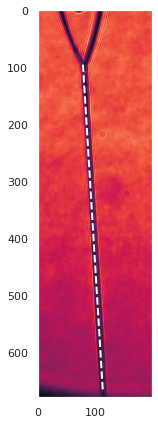

In [23]:

# There's a slighy tilt of the liquid sheet which means the scan is not perfectly horizontal
# Let's estimate the tilt
plt.figure(figsize=(2.5, 6))
plt.imshow(sidemic[0][600:,300:500])
plt.plot([79,114], [95, 670],'w--', lw=2)
plt.grid(None)
lj_angle = np.arctan2(670-95,79-114)
print("Tilt angle %f\u03C0 radians" % (lj_angle/np.pi))
plt.tight_layout()
plt.savefig('../figures/LJ_r194_tilt_angle.pdf')
plt.show()

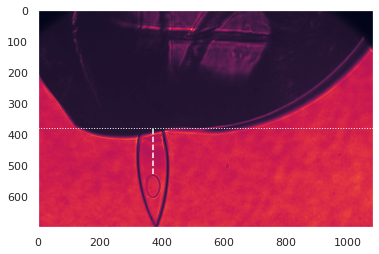

In [24]:
# Now need to find the distance to the nozzle
sidemic_194 = sidemic.data[0]
plt.figure()
plt.imshow(sidemic_194[0:700,:])
nozzle_end = 380
plt.axhline(y=nozzle_end,color='w',ls=':',lw=1)
# plamsa too weak for finding the beam
#xray_pos = np.unravel_index(np.argmax(sidemic_194),sidemic_194.shape)
xray_pos = (526, 371)
plt.plot((xray_pos[1], xray_pos[1]), (xray_pos[0], nozzle_end), 'w--')
plt.grid(None)
plt.show()
distance_to_nozzle_194 = (xray_pos[0]-nozzle_end)*0.0013

In [25]:
depth_194 = IPA_thickness(radavg_train, xgm_train)
# Because the whole injector pivots around a point a motion of the motor_x does not move the liquid sheet by that amount but has to be scaled
# We estimated this scale factor based on drawings of the injector
motor_x_scale_factor = 133/750
motor_194 = motor_x * motor_x_scale_factor

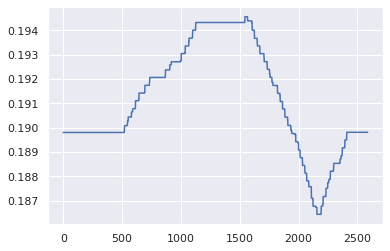

In [26]:
vertical_shift_194 = -(motor_194-motor_194[0])*np.cos(lj_angle)
vertical_pos_194 = vertical_shift_194 + distance_to_nozzle_194
plt.figure()
plt.plot(vertical_pos_194)
plt.savefig('../figures/LJ_r194_vertical_shift.pdf')
plt.show()

In [27]:
# interpolate run 193 to get depth as a function of vertical pos
depth_193_unique = []
motor_193_unique = np.unique(np.round(motor_193,2))
for x in motor_193_unique:
    depth_193_unique.append(depth_193[np.round(motor_193,2) == x].mean())
            

depth_f_y = scipy.interpolate.interp1d(x = motor_193_unique, y=depth_193_unique, kind='quadratic')

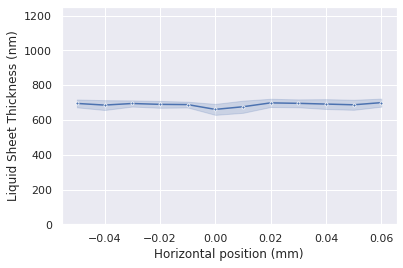

In [29]:
# 1650 to 2150 corresponds to one continuous scan without hitting the edges of the sheet
plt.figure()
v_norm = depth_f_y(vertical_pos_194[1650:2150])/np.mean(depth_f_y(vertical_pos_194[1650:2150]))
sns.lineplot(x = np.round((motor_194[1650:2150]-motor_194[0]),2), y=depth_194[1650:2150]/v_norm, errorbar=('sd',1), marker='.', markers=True)
plt.xlabel('Horizontal position (mm)')
plt.ylabel('Liquid Sheet Thickness (nm)')
#plt.xlim([None,8.2])
plt.ylim([0,1250])
plt.savefig('../figures/S2_LJ_r194_horizontal_scan_thickness_fit.pdf')
plt.show()